In [10]:
#This code mimicks the fetch_openml function from sklearn.datasets as used in the textbook, 

from tensorflow.keras.datasets import mnist
import numpy as np
from sklearn.utils import Bunch

# Load the MNIST dataset from TensorFlow
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Combine training and test sets
X = np.vstack([x_train, x_test])  # Combine image data
y = np.hstack([y_train, y_test])  # Combine labels

# Flatten 28x28 images to 1D arrays (784 features)
X = X.reshape(X.shape[0], -1)

# Convert data to float32 (to match fetch_openml)
X = X.astype('float32')

# Mimic fetch_openml's return format using a Bunch
mnist = Bunch(data=X, target=y)
#This is the same as the textbook, but the data is now in the same format as the MNIST dataset from TensorFlow.
# Access features and target as in the textbook
X, y = mnist.data, mnist.target
#There are 70,000 images each with 784 features which represents the 28 x 28 pixels. 
print("Features (X) shape:", X.shape)  # (70000, 784)
#Labels contain a single value for each image, indicating it's class. No columns as it is not a multi-dimensional array.
print("Labels (y) shape:", y.shape)    # (70000,)


Features (X) shape: (70000, 784)
Labels (y) shape: (70000,)


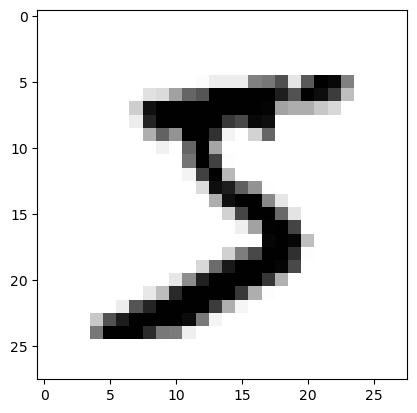

5

In [14]:
#To look at one digit from the dataset, we need to grab an instance's feature vector, reshape it to the 28x28 array, and display
#it using matplotlib imshow() function. We use cmap_'binary' as an argument to make a greyscale color ma where 0 is white and 255 is black

import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap= "binary")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

y[0]
#This is the label for the first image in the dataset. 

In [15]:
#This step splits the dataset into training and test sets, with the training set containing 60,000 images 
# and the test set containing 10,000 images.
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [24]:
#Training a binary classifier to identify a single digit, say 5, we need to create a target vector for this classification task.
#This first step creates the target vectors for our classification task
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

# Check unique values in y_train_5
print("Unique values in y_train_5:", set(y_train_5))

print("Unique values in y_train:", set(y_train))


Unique values in y_train_5: {False, True}
Unique values in y_train: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [26]:
#Now we have to pick a classifier and train it. In this example we use stochastic gradient descent (SGD)
#We do this by using Scikit_Learn's SGDClassifier, which can handle very large datasets efficiently
#SGD is well suited for online learning, in this case we create a SGD classifier and train it on the whole training set

from sklearn.linear_model import SGDClassifier
#Here we assign the variable sgd_clf to this SGDClassifier we create, we can then call methods on this var to train the model
sgd_clf = SGDClassifier(random_state = 42)
#X_train still represents the features (pixel data of images) regardless of whether you're performing binary or 
#multiclass classification
#model learns patterns in X_train to predict whether the corresponding label in y_train_5 is True or false
#y_train_5 is a modified version of y_train labels where it contains true or false if it is 5 or not.
sgd_clf.fit (X_train, y_train_5)
#we feed the argument of the image of digit 5, the classifier guesses the image represents a 5 (true)
sgd_clf.predict([some_digit])



array([ True])

In [28]:
#The next step is evaluating model performance, one way is to use cross_validation
#we can use cross_val_score() to evaluate our SGDClassifier model using k-fold cross falidation with 3 folds
#Recall, k-fold cross validation means splitting training set into k folds, then training the modle k times, holding
#a different fold each time for evaluation

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring = "accuracy")

#Output shows accuracy (ratio of correct predictions) for the 3 folds


array([0.9353 , 0.9632 , 0.94965])

In [30]:
#The results look good, but what if we compare them to a dummyclassifer that just classifies all images to the most frequent class
#In this case it would be negative class (not 5)

from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train))) #always gives false

#evaluating this model's performance

cross_val_score(dummy_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

False


array([0.90965, 0.90965, 0.90965])

In [31]:
#Results of dummyclassifier show it doesn't perform much worse than our model when using accuracy as the scoring mechanism
#Generally, accuracy is not a preferred performance measure for classifiers especially when dealing with skewed datasets
#E.g in our case some classes are more frequent than others (false more common than true), a better method is using a confusion matrix

#General idea is to count the number of instances where class A are classified as class B, for all A/B pairs
#E.g, to know the number of times the classifier confused images of 8s with 0s, you look at row 8, column 0 of the matrix
#To compute, we first need a set of predictions to be compared to actual targets using cross_val_predict() function

from sklearn.model_selection import cross_val_predict

#this function performs k-fold cross-validation, but instead of returning the evaluation scores, it returns the predicitons made on each test fold. 
#meaning the model makes predictions on data it never saw during training (a clean prediction)
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [32]:
#We then can create the confusion matrix suing the confusion_matrix() function. We pass the target class y_train_5 and predicted
#y_train_pred to do this

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm
#Each row in the confusion matrix represents an actual class, while each column represents a predicted class. First row considers non-5 images
#of which 52533 were correctly classified as non 5s and 2046 incorrectly classfied as 5s (false positives)
# second row considers images of 5s, positive class
#of which 991 were incorrectly classified as non 5s (false negatives), and 4430 were correctly classified (true positives)

#A perfect classifier would only have true positives and true negatives, so it would have nonzero values only on 
# main diagonal of top left to bottom right



array([[52533,  2046],
       [  991,  4430]])

In [39]:
#There are alternative classifier metrics we can use to evaluate our models, such as precision and recall, which can be accessed through 
#scikitlearn using precision_score and recall_score

from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred)) #Precision measures the accuracy of positive predictions
# In our context: Out of all images that the model predicted as 5, what fraction were actually 5s
# Precision = 4,430/(4,430 + 2046) = 0.684
# Interpretation: When your model says this is a 5, it's right about 68.4% of the time
print(recall_score(y_train_5, y_train_pred)) #Recall score measures how many actual positive cases were correctly identified
# In our context: Out of all actual 5s in the dataset, what fraction did the model correctly identify?
# Recall = 4,430/(4,430+991) = 81.7%
#Interpretation: The model correctly identifies about 81.7% of the actual 5s in the dataset

#We may also combine precision and recall into a single metric called the F1 score, which is the harmonic mean of precision and recall
#While the regular mean treats all values equally, the harmonic mean gives much more weight to lower values.
#Thus, the classifier will only get a high F1 score if both recall and precision are high.

from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

#F1 score favors classifiers that have similar precision and recall, but this is not always what we want.
#For example if we trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier
#that rejects many good videos (low recall) but only keeps safe ones (high precision).
#On the other hand, a shoplifting classifier would preferably have high recall and lower precision. This means
#The security would get a few false alerts but almost all shoplifters will get caught.


0.6840642371834466
0.8171923999262128


0.7447255610658149

In [ ]:
#Leave this empty for going back and doing the model comparisons with PR curve and ROC Curve from pg. 116-119